## loading model

In [1]:
import os
import torch
import torchvision
import numpy as np
import cv2
import time
from PIL import Image
import matplotlib.pyplot as plt

from new_rcnn import newrcnn_resnet50_fpn

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = newrcnn_resnet50_fpn(pretrained=True, weights="new_rcnn.pth")
model.to(device)

model.eval()

NewRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          

In [3]:
transform = torchvision.transforms.ToTensor()
skel = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

def vis(img, result, mode) :
    if mode==1 : # key
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for i in range(len(result[0]['keypoints'])) :
            if int(result[0]['labels'][i]) is not 1 or result[0]['scores'][i]<0.9 :
                continue

            for j in zip(result[0]['keypoints'][i], result[0]['keypoints_scores'][i]) :
                if j[1] > 1 :
                    cv2.circle(img, (int(j[0][0]), int(j[0][1])), 10, (150, 150, 150), -1)

            for k, (p1, p2) in enumerate(skel) :
                if result[0]['keypoints_scores'][i][p1-1]<1  or result[0]['keypoints_scores'][i][p2-1]<1 :
                    continue
                x1, y1, _ = result[0]['keypoints'][i][p1-1]
                x2, y2, _ = result[0]['keypoints'][i][p2-1]
                if k in [12, 13, 14, 15, 16, 17, 18] :
                    color = (255, 92, 92)      
                elif k in [8, 10, 0, 1] :
                    color = (255, 248, 94)        
                elif k in [9, 11, 2, 3] :
                    color = (255,168,96)      
                else :
                    color = (111, 186, 255)
                cv2.line(img, (x1, y1), (x2, y2), color, 5)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    else : 
        mask_img = np.zeros((480, 640), dtype='uint8')
        threshold = np.ones((480, 640), dtype='uint8') * 0.5
        if len(result[0]['masks']) != 0:
            masks = result[0]['masks'].cpu().numpy()
            for z in range(len(masks)):
                temp = np.greater(masks[z][0], threshold)
                mask_img = np.logical_or(mask_img, temp)
            mask_img = mask_img * 255
            mask_img = mask_img.astype('uint8')
            mask_img = np.stack([mask_img, mask_img, mask_img], axis=2)
        return mask_img            

## inference single image

In [4]:
img = cv2.imread('data/ski.jpg')

tic = time.time()
result = model([transform(img).to(device)])
processed = vis(img, result, 1)
toc = time.time()
print ('processing time is %.5f' % (toc - tic))

processing time is 0.10909


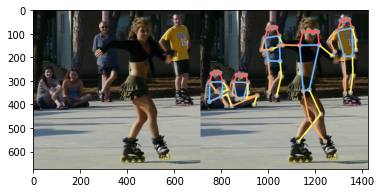

In [5]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)

plt.imshow(np.concatenate([img, processed], axis=1))

## inference video

In [ ]:
# cap = cv2.VideoCapture('data/video.mp4')
cap = cv2.VideoCapture(0)

mode = 1 

with torch.no_grad():
    while(cap.isOpened()) :
        ret, img = cap.read()
        
        if ret == False:
            break
        
        result = model([transform(img).to(device)])
        processed = vis(img, result, mode)

        cv2.imshow("processed", processed)
        
        k = cv2.waitKey(33)
        if  k == 27 or k == 113 :
            break
        if k == 32 :
            mode *= (-1)

cap.release()
cv2.destroyAllWindows()